## Diffusion Denoising visualization Script

It is very difficult to infer if the model is learning to denoising correctly, just by looking into final inference samples. Its important to have insights into model to determine its hyperparameters. So, I have created this script to replicate the denoising training settings: where we take a clean sample and add noise till specified timestep and visualize the model predictions on it.

As per recent develoment of diffusion model training process, I have added support for 3 popular prediction types: 
1. Epsilon: where model predicts the noise (default)
2. Sample: where model predicts denoised sample directly
3. V prediction: Model computes a velocity term (see section 2.4 of [Imagen Video](https://imagen.research.google/video/paper.pdf) paper).

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch

In [2]:
from diffusion3d import *

In [3]:
config = TrainingConfig()
dataset = VoxelDataset(root_dir='shape_net_voxel_data_v1')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True,num_workers=5,persistent_workers=True)
model = Unet3D(init_dim=32,dim=32,dim_mults=[1,2,4,8])
model.load_state_dict(torch.load(os.path.join(config.output_dir, 'model')))
#3d-ddpm-chair-vpred'
noise_scheduler = DDIMScheduler.from_config(config.scheduler_config,rescale_betas_zero_snr=True,
                                            timestep_spacing="trailing",prediction_type = "v_prediction")

In [4]:
### visualization utility for voxel grids

import deepdish as dd
from matplotlib import pyplot as plt
import numpy as np
import plyfile
from plyfile import PlyData, PlyElement

def get_coords(dims):
    x = np.linspace(-1, 1, dims)
    y = np.linspace(-1, 1, dims)
    z = np.linspace(-1, 1, dims)

    x_1, y_1, z_1 = np.meshgrid(x, y,z)
    return np.stack([x_1,y_1,z_1])

def save_to_ply( filename, points):
    assert points.ndim == 2 and points.shape[1] == 3, "Points should be a Nx3 array"

    vertex = np.array(
        [(p[0], p[1], p[2]) for p in points],
        dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')]
    )

    ply_element = PlyElement.describe(vertex, 'vertex')

    PlyData([ply_element]).write(filename)
    
def plot_single_voxel_graph(ax,coords,voxels):
  mask = voxels[:,:,:] > 0

  points = np.array([coords[0,mask],coords[1,mask],coords[2,mask]]).T
  ax.scatter(points[:,0],points[:,1],points[:,2],s=1,vmin=-1,vmax=1,c='k')

  return points
def plot_voxels(voxels,save_ply=False):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  coords = get_coords(32)

  points =plot_single_voxel_graph(ax,coords,voxels)
  plt.show()

  if save_ply:
    save_to_ply('object.ply',points)

In [5]:
### calculate the original sample from velocity pred by model and input noisy image
### (see section 2.4 of [Imagen Video](https://imagen.research.google/video/paper.pdf) paper).

def get_orig_from_velocity(model_output,timestep,sample,scheduler):
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    beta_prod_t = 1 - alpha_prod_t
    pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
    if scheduler.config.thresholding:
            pred_original_sample = scheduler._threshold_sample(pred_original_sample)
    elif scheduler.config.clip_sample:
        pred_original_sample = pred_original_sample.clamp(
            -scheduler.config.clip_sample_range, scheduler.config.clip_sample_range
        )

    return pred_original_sample

torch.Size([4, 32, 32, 32])


/tmp/ipykernel_1874308/3922832680.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(points[:,0],points[:,1],points[:,2],s=1,vmin=-1,vmax=1,c='k')


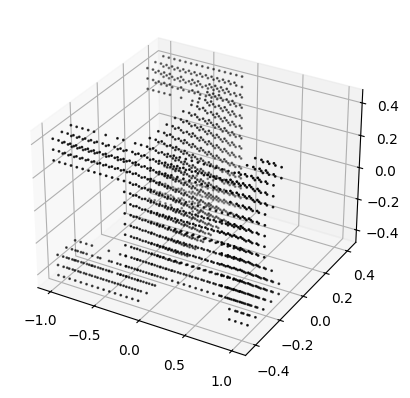

-1.0 1.0
torch.Size([4, 32, 32, 32])


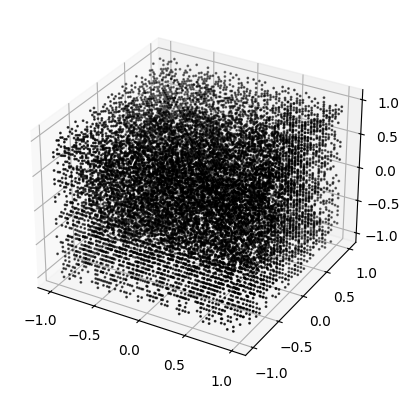

-3.8937864 4.1884522


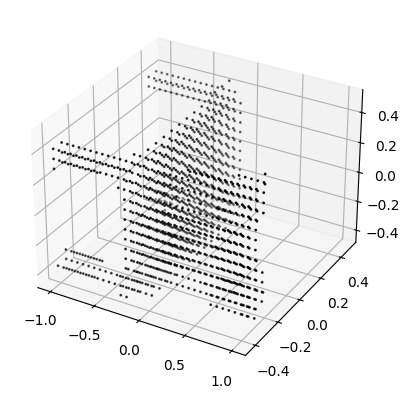

-1.0 1.0


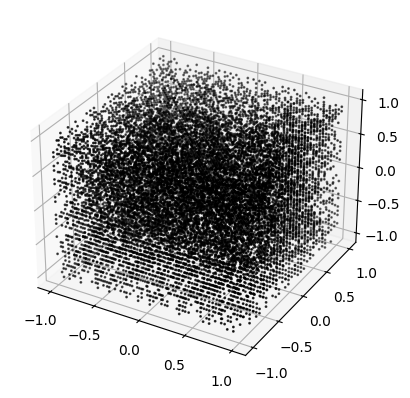

-3.8736446 4.332827


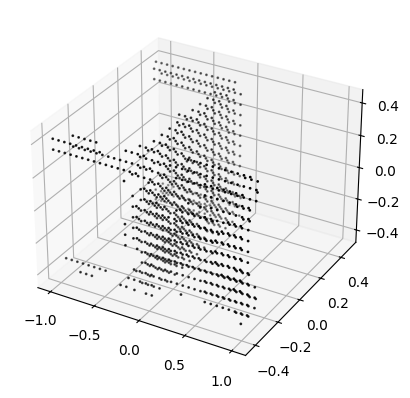

-1.0 1.0


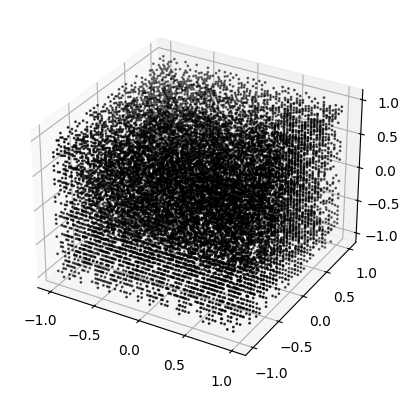

-3.8299918 4.4509034


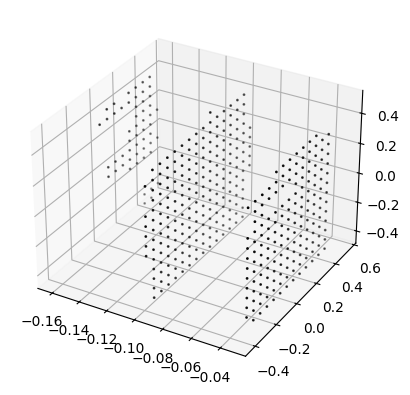

-1.0 1.0


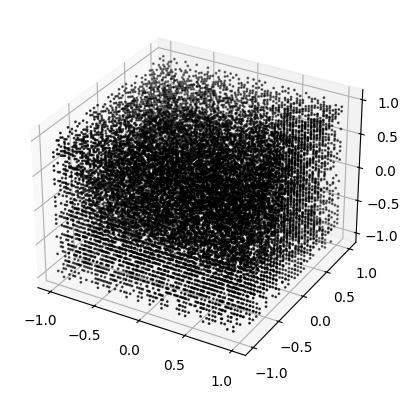

-3.7708187 4.534093


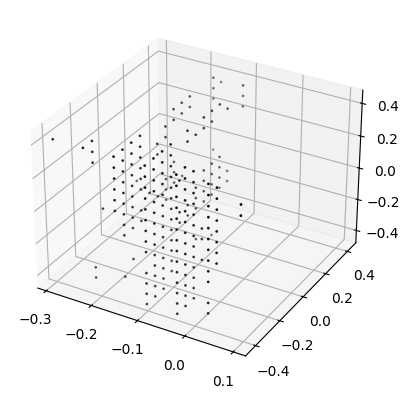

-1.0 0.27031413


In [6]:
for batch in dataloader:
    print(batch.shape)
    voxels = batch[0].numpy()
    plot_voxels(voxels)
    print(voxels.min(),voxels.max())
    print(batch.shape)
    clean_images = batch.to(device).unsqueeze(1)
    # Sample noise that we'll add to the images
    noise = torch.randn(clean_images.shape,device=device)
    bs = clean_images.shape[0]
    
    # Sample a random timestep for each image
    timesteps = torch.tensor([850,900,950,995],device=device).unsqueeze(1)

    # Add noise to the clean images according to the noise magnitude at each timestep
    # (this is the forward diffusion process)
    for time in timesteps:
        ### visualize the noisy image

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, time)
        v_noisy = noisy_images[0,0].detach().cpu().numpy()
        plot_voxels(v_noisy)
        print(v_noisy.min(),v_noisy.max())
        
        # denoising
        noise_pred = model(noisy_images, time)
        
        if noise_scheduler.config.prediction_type == "v_prediction":
            v_recon = get_orig_from_velocity(noise_pred,time,noisy_images,noise_scheduler)
            v_recon = v_recon[0,0].detach().cpu().numpy()
        
        elif noise_scheduler.config.prediction_type == "epsilon":
            v_recon = (noisy_images-noise_pred)[0,0].detach().cpu().numpy()
        
        elif noise_scheduler.config.prediction_type == "sample":
            v_recon = noise_pred[0,0].detach().cpu().numpy()
        
        plot_voxels(v_recon)
        print(v_recon.min(),v_recon.max())
    break

In [ ]:
# ### Velocity prediction visualization
# for batch in dataloader:
#     print(batch.shape)
#     voxels = batch[0].numpy()
#     plot_voxels(voxels)
#     print(voxels.min(),voxels.max())
#     print(batch.shape)
#     clean_images = batch.to(device).unsqueeze(1)
#     # Sample noise that we'll add to the images
#     noise = torch.randn(clean_images.shape,device=device)
#     bs = clean_images.shape[0]
    
#     # Sample a random timestep for each image
#     timesteps = torch.tensor([850,900,950,995],device=device,dtype=torch.int).unsqueeze(1)
    
#     # Add noise to the clean images according to the noise magnitude at each timestep
#     # (this is the forward diffusion process)
#     for time in timesteps:
#         noisy_images = noise_scheduler.add_noise(clean_images, noise, time)
#         v_noisy = noisy_images[0,0].detach().cpu().numpy()
#         plot_voxels(v_noisy)
#         print(v_noisy.min(),v_noisy.max())
#         # denoising
#         noise_pred = model(noisy_images, time)
#         # if time >800:
#         #     v_recon = (noise_pred)[0,0].detach().cpu().numpy()
#         v_recon = get_orig_from_velocity(noise_pred,time,noisy_images,noise_scheduler)
#         v_recon = v_recon[0,0].detach().cpu().numpy()
#         #(noisy_images-noise_pred)[0,0].detach().cpu().numpy()
#         plot_voxels(v_recon)
#         print(v_recon.min(),v_recon.max())
#     break

In [ ]:
# ### for v_prediction
# for batch in dataloader:
#     print(batch.shape)
#     voxels = batch[0].numpy()
#     plot_voxels(voxels)
#     print(voxels.min(),voxels.max())
#     print(batch.shape)
#     clean_images = batch.to(device).unsqueeze(1)
#     # Sample noise that we'll add to the images
#     noise = torch.randn(clean_images.shape,device=device)
#     bs = clean_images.shape[0]
    
#     # Sample a random timestep for each image
#     timesteps = torch.tensor([700,800,900,995],device=device).unsqueeze(1)

#     # Add noise to the clean images according to the noise magnitude at each timestep
#     # (this is the forward diffusion process)
#     for time in timesteps:
#         noisy_images = noise_scheduler.add_noise(clean_images, noise, time)
#         v_noisy = noisy_images[0,0].detach().cpu().numpy()
#         plot_voxels(v_noisy)
#         print(v_noisy.min(),v_noisy.max())
#         # denoising
#         noise_pred = model(noisy_images, time)
#         if time >800:
#             v_recon = (noise_pred)[0,0].detach().cpu().numpy()
#         v_recon = (noisy_images-noise_pred)[0,0].detach().cpu().numpy()
#         plot_voxels(v_recon)
#         print(v_recon.min(),v_recon.max())
#     break